# **Analysis for Disaster Tweet Classification**

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)


Using TensorFlow backend
TensorFlow version: 2.17.1
KerasNLP version: 0.18.1


# **Exploratory Data Analysis**

**1. Dataset Overview & Memory Usage**

This analysis aims to understand the **structure of the dataset, handle missing values, and explore key patterns** that might help in building a robust NLP classification model

In [30]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [31]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
df_train.info()
df_train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


**2. Handling Missing Values**

Missing data can impact model performance. We analyze missing values for keyword and location columns

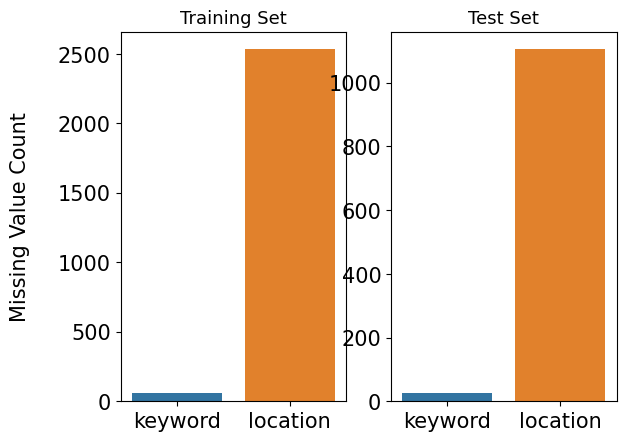

In [34]:
missing_features = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, dpi=100)

sns.barplot(x=df_train[missing_features].isnull().sum().index, y=df_train[missing_features].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_features].isnull().sum().index, y=df_test[missing_features].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()


In [35]:
# Calculate missing percentages for training data
train_missing_pct = df_train[missing_features].isnull().mean() * 100

# Calculate missing percentages for test data
test_missing_pct = df_test[missing_features].isnull().mean() * 100

# Print the percentages
print("Train missing percentages:")
print(train_missing_pct)

print("\nTest missing percentages:")
print(test_missing_pct)

Train missing percentages:
keyword      0.801261
location    33.272035
dtype: float64

Test missing percentages:
keyword      0.796813
location    33.864542
dtype: float64


The distribution of the missing values in training and test is similar. We need not worry about the imbalance in that.

In [36]:
for df in [df_train, df_test]:
    df[['keyword', 'location']] = df[['keyword', 'location']].fillna({
        'keyword': 'no_keyword',
        'location': 'no_location'
    })

 We replace missing keyword and location values with "no_keyword" and "no_location" respectively.
This avoids losing information while ensuring the model doesn't interpret NaN values as meaningful signals.

In [37]:
print(df_train['keyword'].isnull().sum())
print(df_test['keyword'].isnull().sum())

0
0


**3. Keywords and Disaster Distribution**

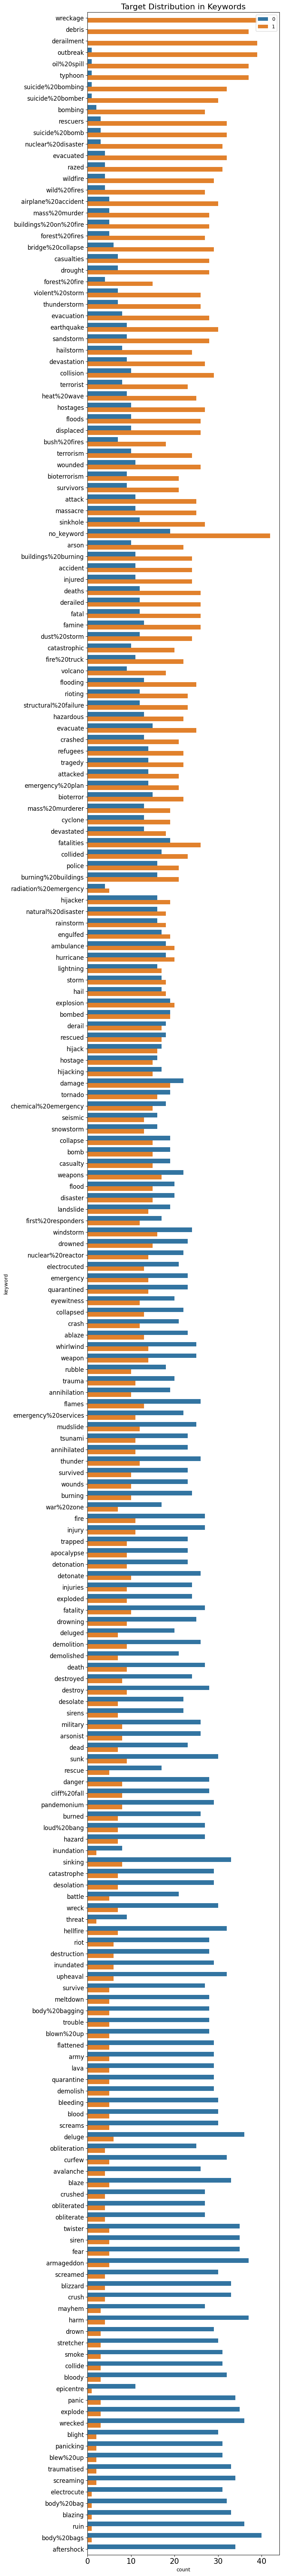

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute mean target for each keyword and sort the DataFrame by it.
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
sorted_df = df_train.sort_values(by='target_mean', ascending=False)

# 2. Create the plot using subplots
fig, ax = plt.subplots(figsize=(8, 72), dpi=100)
sns.countplot(data=sorted_df, y='keyword', hue='target', ax=ax)

# 3. Customize the plot appearance
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper right')
ax.set_title('Target Distribution in Keywords', fontsize=16)

plt.tight_layout()
plt.show()

# 4. Clean up by removing the temporary column
df_train.drop(columns=['target_mean'], inplace=True)


Certain keywords alone are strong disaster indicators – "typhoon", "evacuated", "mass murder" almost always indicate disasters. Contextual ambiguity – Some words (e.g., "panic", "smoke") may appear in both disaster and non-disaster tweets.

**4. Unique keywords and locations**

In [20]:
# Check number of unique keywords and locations
print (df_train.location.nunique(), df_test.location.nunique())

3342 1603


As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

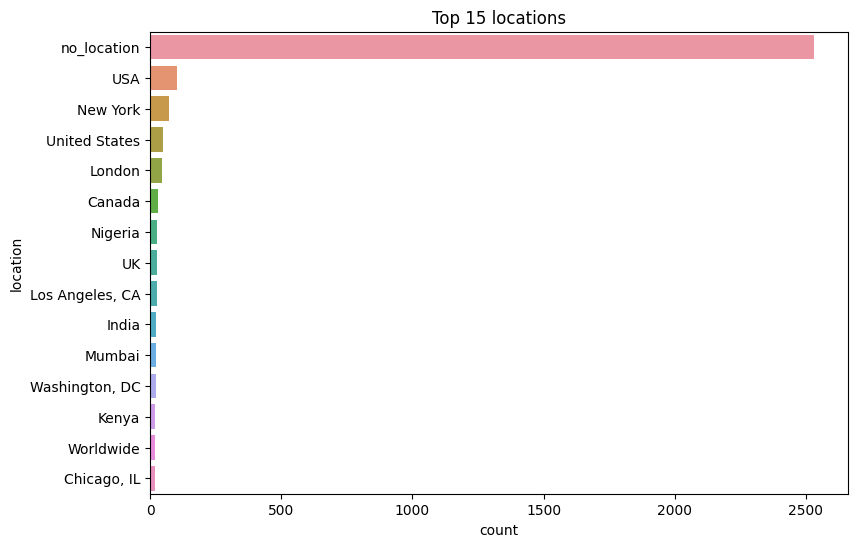

In [21]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y= df_train.location, order = df_train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

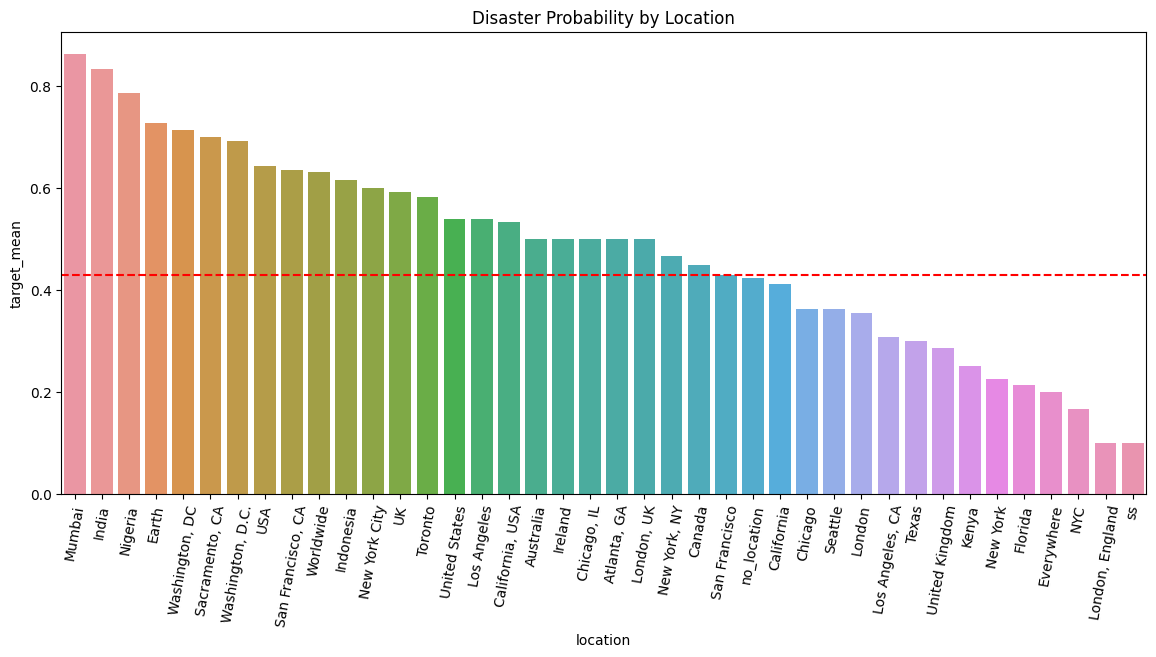

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'target' is numeric
df_train['target'] = pd.to_numeric(df_train['target'], errors='coerce')

# Get top locations with 10+ occurrences
raw_loc = df_train.location.value_counts()
top_loc = list(raw_loc[raw_loc >= 10].index)

# Filter dataset for only top locations
top_only = df_train[df_train.location.isin(top_loc)]

# Compute mean disaster probability per location
top_l = top_only.groupby('location')['target'].mean().sort_values(ascending=False)

# Convert to DataFrame for seaborn
top_l = top_l.reset_index()
top_l.columns = ['location', 'target_mean']

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=top_l, x='location', y='target_mean')

# Add mean disaster rate as a reference line
plt.axhline(df_train['target'].mean(skipna=True), linestyle='dashed', color='red')

# Format labels
plt.xticks(rotation=80)
plt.title("Disaster Probability by Location")
plt.show()

The top 3 locations with highest % of disaster tweets are Mumbai, Inida, and Nigeria. As the location data is not clean, we see some interesting cases, such as 'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average. We try to clean up the location and see if there is any difference:

**5. Target Distribution**


Target Distribution (0 = Not Disaster, 1 = Disaster):
target
0    4342
1    3271
Name: count, dtype: int64


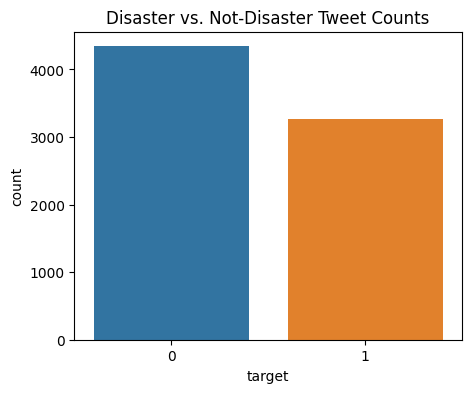


Approx. ratio of disaster tweets: 42.97%


In [12]:
print("\nTarget Distribution (0 = Not Disaster, 1 = Disaster):")
print(df_train['target'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(data=df_train, x='target')
plt.title("Disaster vs. Not-Disaster Tweet Counts")
plt.show()

disaster_ratio = df_train['target'].mean()
print(f"\nApprox. ratio of disaster tweets: {disaster_ratio*100:.2f}%")

The dataset is fairly balanced (~57% non-disaster, ~43% disaster). No extreme class imbalance, so no need for oversampling/undersampling.

**6. Word & Character Count Analysis**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

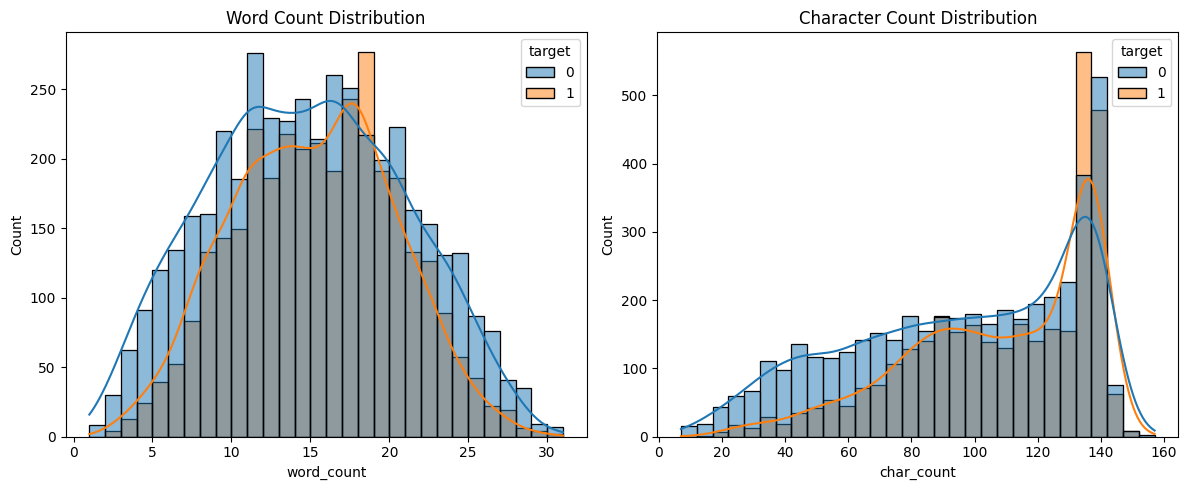


Average word count for Not-Disaster tweets: 14.704744357438969
Average word count for Disaster tweets: 15.167532864567411

Average character count for Not-Disaster tweets: 95.70681713496084
Average character count for Disaster tweets: 108.11342097217977


In [28]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))

plt.figure(figsize=(12,5))

# Word Count Distribution by Class
plt.subplot(1,2,1)
sns.histplot(data=df_train, x='word_count', hue='target', kde=True, bins=30)
plt.title("Word Count Distribution")

# Character Count Distribution by Class
plt.subplot(1,2,2)
sns.histplot(data=df_train, x='char_count', hue='target', kde=True, bins=30)
plt.title("Character Count Distribution")

plt.tight_layout()
plt.show()

print("\nAverage word count for Not-Disaster tweets:",
      df_train.loc[df_train['target']==0, 'word_count'].mean())
print("Average word count for Disaster tweets:",
      df_train.loc[df_train['target']==1, 'word_count'].mean())

print("\nAverage character count for Not-Disaster tweets:",
      df_train.loc[df_train['target']==0, 'char_count'].mean())
print("Average character count for Disaster tweets:",
      df_train.loc[df_train['target']==1, 'char_count'].mean())

Not a lot of difference in word count between word count, characters are a little more in Disaster ones but not significantly so.

**7. WordCloud - What does our data look like?**

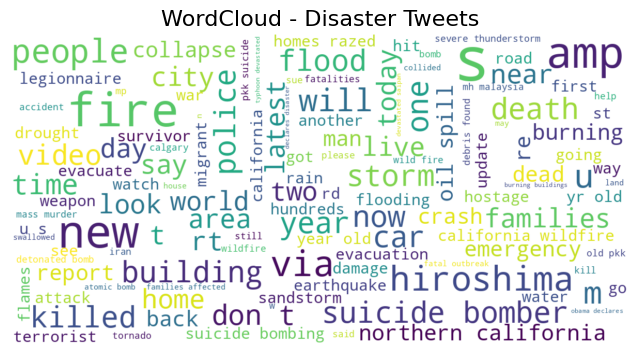

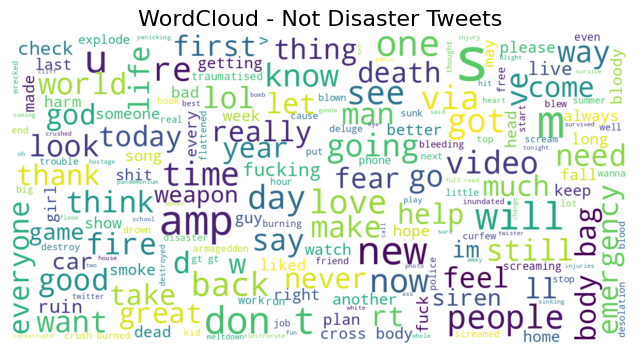

In [37]:
import re
from wordcloud import WordCloud, STOPWORDS

def basic_cleaning(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)     # remove URLs
    text = re.sub(r"@\w+", " ", text)        # remove mentions
    text = re.sub(r"[^a-zA-Z#]", " ", text)  # keep letters and hashtag
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces
    return text

df_train['clean_text'] = df_train['text'].apply(basic_cleaning)

# Split into Disaster / Not Disaster
disaster_text = " ".join(df_train.loc[df_train['target']==1, 'clean_text'])
not_disaster_text = " ".join(df_train.loc[df_train['target']==0, 'clean_text'])

def plot_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42
                         ).generate(str(text))
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

# WordCloud for Disaster Tweets
plot_wordcloud(disaster_text, "WordCloud - Disaster Tweets")

# WordCloud for Not Disaster Tweets
plot_wordcloud(not_disaster_text, "WordCloud - Not Disaster Tweets")

**8. Special Tokens (Mentions, Hashtags, URLs, Punctuation)**


Average Special Token Counts by Class (0=Not Disaster, 1=Disaster):
        mention_count  url_count  hashtag_count  exclam_count  question_count
target                                                                       
0            0.420313   0.507370       0.388761      0.194150        0.544450
1            0.272088   0.769795       0.501987      0.100887        0.232956


<Figure size 1200x500 with 0 Axes>

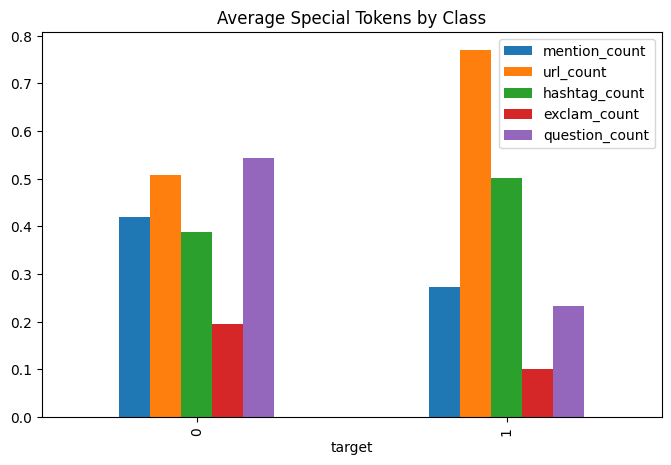

In [38]:
def count_special_tokens(text):
    # Example counters
    mention_count   = len(re.findall(r"@\w+", text))
    url_count       = len(re.findall(r"http\S+", text))
    hashtag_count   = len(re.findall(r"#\w+", text))
    exclamation_cnt = text.count("!")
    question_cnt    = text.count("?")
    return mention_count, url_count, hashtag_count, exclamation_cnt, question_cnt

df_train['mention_count'], df_train['url_count'], df_train['hashtag_count'], \
df_train['exclam_count'], df_train['question_count'] = zip(*df_train['text'].apply(count_special_tokens))

# Look at average counts by class
agg_special = df_train.groupby('target')[['mention_count','url_count','hashtag_count','exclam_count','question_count']].mean()
print("\nAverage Special Token Counts by Class (0=Not Disaster, 1=Disaster):")
print(agg_special)

# We can also visualize:
plt.figure(figsize=(12,5))
agg_special.plot(kind='bar', figsize=(8,5), title="Average Special Tokens by Class")
plt.show()

**Disaster tweets have**:
More URLs (news links, emergency resources), More hashtags (for awareness, trending topics), More exclamation marks (panic, urgency).
**Non-disaster tweets use**:
More mentions (@usernames), likely from casual discussions, More question marks (asking about the event rather than reporting it).

**9. Model Selection**

In our previous notebooks, we tried models like **logistic regression, DistilBert, RobBerta** and then the best models given our CPU, GPU constraints was the Bertweet. Given that it is trained on Twitter data it understands the semantic nature of keywords. We used the model **vinai/bertweet-base** from Hugging Face.

In [14]:
!pip install transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [15]:
# Install necessary libraries if not already installed
# !pip install transformers datasets torch pandas numpy

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


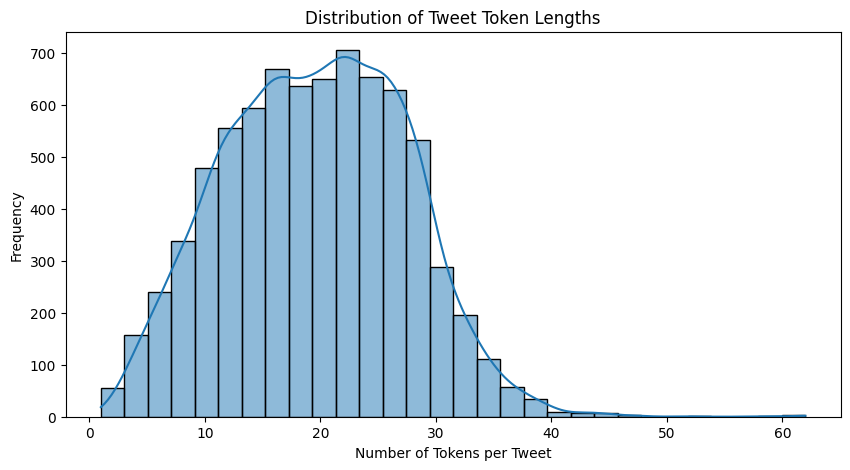

In [16]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

# Tokenize all tweets
tweet_lengths = [len(tokenizer.tokenize(text)) for text in df_train["text"]]

# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(tweet_lengths, bins=30, kde=True)
plt.xlabel("Number of Tokens per Tweet")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Token Lengths")
plt.show()

For optimal usage of our resources, we kept max tokens as 32 as we can see the distribution of the tokens per tweet.

In [31]:
import torch
import pandas as pd
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [58]:
import nltk
import os

# Manually set NLTK data directory
nltk_data_dir = "/usr/local/nltk_data"
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Download WordNet & Language Support
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)

print("✅ WordNet successfully installed and configured!")


[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data] Downloading package omw-1.4 to /usr/local/nltk_data...
✅ WordNet successfully installed and configured!


In [ ]:
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

**Split into training & validation sets**

In [21]:

X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["target"], test_size=0.2, random_state=42, stratify=df_train["target"])

# Tokenize
train_tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=128, return_tensors="pt")
val_tokens = tokenizer(list(X_val), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create TensorDatasets
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
val_dataset = TensorDataset(val_tokens["input_ids"], val_tokens["attention_mask"], val_labels)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Adam Optimizer with the optimum learning rate for tuning our model

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [ ]:
num_epochs = 3
best_val_loss = float("inf")
patience, patience_counter = 2, 0  # Early stopping parameters

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    # Validation Step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, axis=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_bertweet_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

Looking at the best models from our Epochs

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_bertweet_model.pth"))


test_tokens = tokenizer(df_test["text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Predict on test set
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1)
        predictions.extend(preds.cpu().numpy())

In [ ]:
# 7. Generate Submission File
# ------------------------------
submission = pd.DataFrame({"id": df_test["id"], "target": predictions})
submission.to_csv("bertweet_submission.csv", index=False)

print("Submission file created successfully!")

Further Experiments for Optimisation 

In [22]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_metrics = []


num_epochs = 2  # Can be increased for final training
batch_size = 16
gradient_accumulation_steps = 2  # Accumulate gradients every 2 steps
learning_rate = 2e-5  # Standard for BERT-based models
weight_decay = 0.02



In [23]:
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["target"])):
    print(f"\n========== Fold {fold+1}/{n_splits} ==========")
    
    # Split data for this fold
    train_df = df_train.iloc[train_idx].reset_index(drop=True)
    val_df   = df_train.iloc[val_idx].reset_index(drop=True)
    
    # Tokenize with optimized sequence length (from EDA)
    max_seq_length = 64  # Adjusted after EDA

    train_tokens = tokenizer(
        list(train_df["text"]), padding="max_length", truncation=True, max_length=max_seq_length, return_tensors="pt"
    )
    val_tokens = tokenizer(
        list(val_df["text"]), padding="max_length", truncation=True, max_length=max_seq_length, return_tensors="pt"
    )

    # Convert labels to tensors
    train_labels = torch.tensor(train_df["target"].values)
    val_labels = torch.tensor(val_df["target"].values)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
    val_dataset = TensorDataset(val_tokens["input_ids"], val_tokens["attention_mask"], val_labels)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    from transformers import get_scheduler

    # Define learning rate scheduler (cosine decay)
    num_training_steps = len(train_loader) * num_epochs
    lr_scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)


    best_val_loss = float("inf")
    patience, patience_counter = 2, 0
    best_val_loss = float("inf")
    patience, patience_counter = 2, 0  

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps  # Scale loss for accumulation

            # Backward pass
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:  # Update weights every `gradient_accumulation_steps`
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # ------------------------------
        # 4.3 Validation Step
        # ------------------------------
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [item.to(device) for item in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                preds = torch.argmax(outputs.logits, axis=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_bertweet_fold{fold}.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Save Metrics
    fold_metrics.append({"fold": fold + 1, "val_loss": best_val_loss, "val_accuracy": val_accuracy})


========== Fold 1/5 ==========


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss = 0.2582, Val Loss = 0.3765, Val Accuracy = 0.8398
Epoch 2: Train Loss = 0.1795, Val Loss = 0.3740, Val Accuracy = 0.8470

========== Fold 2/5 ==========
Epoch 1: Train Loss = 0.1638, Val Loss = 0.2781, Val Accuracy = 0.8930
Epoch 2: Train Loss = 0.1327, Val Loss = 0.3125, Val Accuracy = 0.8917

========== Fold 3/5 ==========
Epoch 1: Train Loss = 0.1153, Val Loss = 0.1957, Val Accuracy = 0.9212
Epoch 2: Train Loss = 0.0893, Val Loss = 0.1828, Val Accuracy = 0.9317

========== Fold 4/5 ==========
Epoch 1: Train Loss = 0.0729, Val Loss = 0.1136, Val Accuracy = 0.9527
Epoch 2: Train Loss = 0.0605, Val Loss = 0.1071, Val Accuracy = 0.9560

========== Fold 5/5 ==========
Epoch 1: Train Loss = 0.0532, Val Loss = 0.0776, Val Accuracy = 0.9645
Epoch 2: Train Loss = 0.0472, Val Loss = 0.1023, Val Accuracy = 0.9488


In [26]:
# Tokenize test data using the same `max_seq_length` as training
test_tokens = tokenizer(
    df_test["text"].tolist(), 
    padding="max_length",  # Ensure padding consistency
    truncation=True, 
    max_length=64,  # Same as used in training
    return_tensors="pt"
)

# Create a DataLoader for batching test inputs
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
import numpy as np

# Store predictions from multiple folds
fold_predictions = []

# Run inference for each saved best model
for fold in range(3, 5):  # Change range based on best-performing folds
    best_model_path = f"best_bertweet_fold{fold}.pth"
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    model.eval()

    preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask = [item.to(device) for item in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())  # Convert to probabilities
    
    fold_predictions.append(np.concatenate(preds, axis=0))

# Average predictions across folds
final_predictions = np.mean(np.array(fold_predictions), axis=0)  # Soft voting

# Convert to final class labels
final_labels = np.argmax(final_predictions, axis=1)

# Save final submission
submission = pd.DataFrame({"id": df_test["id"], "target": final_labels})
submission.to_csv("bertweet_ensemble_submission.csv", index=False)

print("✅ Ensemble submission created successfully! 🚀")


<ipython-input-27-7165d73981d7>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


✅ Ensemble submission created successfully! 🚀


In [49]:
import shutil
 
# Define file path and output filename

file_path = '/kaggle/working/bertweet_submission_new.csv'

output_filename = 'bert_submission_download_new.csv'
 
# Copy the file to a new location for download

shutil.copy(file_path, f'./{output_filename}')
 
# Display the download link

from IPython.display import FileLink

FileLink(f'./{output_filename}')
 

/kaggle/working/bert_submission_download_new.csv

Testing model optimisation

In [23]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [24]:
num_epochs = 3
best_val_loss = float("inf")
patience, patience_counter = 2, 0  # Early stopping parameters

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    # Validation Step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, axis=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_bertweet_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1: Train Loss = 0.4583, Val Loss = 0.3718, Val Accuracy = 0.8549
Epoch 2: Train Loss = 0.3378, Val Loss = 0.3972, Val Accuracy = 0.8444
Epoch 3: Train Loss = 0.2794, Val Loss = 0.3830, Val Accuracy = 0.8569
Early stopping triggered!
